In [1]:
import os
import pandas as pd
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
from dotenv import load_dotenv
from tqdm import tqdm
from langchain_community.vectorstores import Chroma
from langchain.schema import Document
from langchain_openai  import OpenAIEmbeddings

## To run Hugging Face OpenSource models
# Needs to manually install Visual C++ Tools from: https://visualstudio.microsoft.com/visual-cpp-build-tools/
from InstructorEmbedding import INSTRUCTOR
from langchain_community.embeddings import HuggingFaceInstructEmbeddings
import warnings, re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Suppress all warnings
warnings.filterwarnings("ignore")

c:\Users\USER\OneDrive\Python Projects\proyecto_integrador_equipo_27\.venv\Lib\site-packages\InstructorEmbedding\instructor.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


### Set up embedding model to use with GPU

In [2]:
import torch
import torch.nn as nn

# Check if CUDA is available
print(f"CUDA Available: {torch.cuda.is_available()}")

# Print CUDA device name
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
Device Name: NVIDIA GeForce RTX 3050


### Embedding model definition
A technique for representing text data as numerical vectors, which can be input into machine learning models. The embedding model is responsible for converting text into these vectors.

In [3]:
# WARNING! :Only runs with this version
###### !pip install sentence-transformers==2.2.2  ######
#Define the sentence-transformer model:

#For English
#sentence-transformers/LaBSE
#embed_model = "sentence-transformers/all-MiniLM-L6-v2"
embed_model = "sentence-transformers/all-mpnet-base-v2"
#embed_model = "BAAI/bge-multilingual-gemma2"
#embed_model = "dunzhang/stella_en_1.5B_v5"

#For Spanish 
#projecte-aina/aguila-7b
#embed_model = "hiiamsid/sentence_similarity_spanish_es"

#Other sentence-transformer settings
model_kwargs = {'device': 'cuda:0'}  # specify GPU device
encode_kwargs = {'normalize_embeddings': True}

hf_embed_model = HuggingFaceInstructEmbeddings(
    model_name=embed_model,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# Load environment variables from the .env file
#load_dotenv()
# Initialize OpenAI client with the API key from environment variables
#open_ai_embed_model = OpenAIEmbeddings(openai_api_key= os.environ["OPENAI_API_KEY"],
#             model="text-embedding-3-large", 
#             max_retries=1000,
#             request_timeout=8,
#             retry_min_seconds=4,
#             show_progress_bar=True,
#             )

load INSTRUCTOR_Transformer
max_seq_length  512


### Test A: Create index without chunking method

We read a tabular CSV, each row will be a complete chunk

In [ ]:
# Define the persistent directory containing the VectorDB
script_dir =  os.getcwd()
persistent_dir = os.path.abspath(os.path.join(script_dir,'..' ,'index', 'TestA'))

# Importante Leer columna de codigo como string, sino se eliminan los zeros a la izquierda.
df = pd.read_csv('..\data\WebScrap_CSVs\hts_codes_WebScrapped.csv', encoding='utf-8', dtype={'HTS code': str})

# Split data and metadata
texts = df['Description'].tolist()  # This is the text data that will be embedded
metadata = df['HTS code'].tolist()  # This is the metadata that will be stored alongside the embeddings

chroma_db = Chroma(
    collection_name="csv_collection",  # Name for the Chroma collection
    embedding_function=hf_embed_model.embed_query,  # Function for query embeddings
    persist_directory=persistent_dir
)

documents = []
for i, text in enumerate(texts):
    document = Document(page_content=text, metadata={"source": metadata[i]})
    documents.append(document)

# Debug to check metadata + text
print(documents[0])
print(documents[1])    
print("Amount of documents is: " , len(documents))   

vector_db = None
with tqdm(total=len(documents), desc="Creando embeddings...") as pbar:
    for d in documents:
        if vector_db:
            vector_db.add_documents([d])
        else:
            #When no GPU is available
            #vector_db = Chroma.from_documents([d],embed_model, persist_directory=persistent_dir )
            
            #To enable embeddings running on GPU: embedding and ingesting at the same time
            vector_db = Chroma.from_documents([d],hf_embed_model, persist_directory=persistent_dir)
        pbar.update(1)    

### Test B Create index with RecursiveCharacterTextSplitter methodology
We read a flat file (.txt) and data will be read as parapgraphs.

Is the process of breaking down a large input text into smaller pieces.
This ensures that the text fits the input size of the embedding model and improves retrieval efficiency.

Chunk size is one of the key hyperparameters on any LLM project

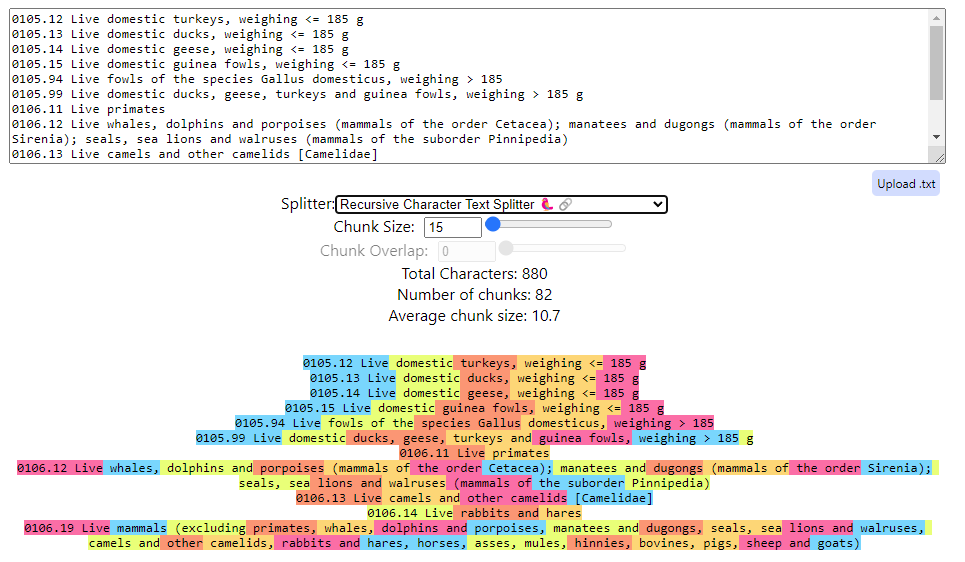

In [ ]:
# Define the persistent directory containing the VectorDB
script_dir = os.getcwd()
persistent_dir = os.path.abspath(os.path.join(script_dir, '..', 'index', 'TestB'))

# Step 1: Read the .txt file
file_path = '..\data\hs_code_dictionary.txt'  # Path to your .txt file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Function to extract metadata (HS code) and content
def extract_metadata_and_content(line):
    match = re.match(r"(\d{4}\.\d{2})\s*(.*)", line)
    if match:
        metadata = match.group(1)  # The number part as metadata
        content = match.group(2)   # The rest of the line as content
        return metadata, content
    return None, line  # In case no match, return the line as-is

# Step 2: Split the text into lines first
lines = text.split("\n")

# Initialize the RecursiveCharacterTextSplitter
chunk_size = 200  # Define your chunk size
chunk_overlap = 20  # Set to 0 if you don't want overlapping chunks

text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

# Step 3: Process each line, extract metadata, split content, and create Document objects
documents = []
for line in lines:
    metadata, content = extract_metadata_and_content(line)
    
    if metadata:  # If we found valid metadata
        # Split the content into chunks
        chunks = text_splitter.split_text(content)
        
        # Create a Document object for each chunk, with metadata containing the HS code
        for chunk in chunks:
            document = Document(page_content=chunk, metadata={"hs_code": metadata, "source": file_path})
            documents.append(document)

# Step 4: Embed the documents into the vector database
vector_db = None
with tqdm(total=len(documents), desc="Creando embeddings...") as pbar:
    for d in documents:
        if vector_db:
            vector_db.add_documents([d])
        else:
            # When no GPU is available, initialize vector_db
            #vector_db = Chroma.from_documents([d], embed_model, persist_directory=persistent_dir)
            
            # To enable embeddings running on GPU, ingest documents and create embeddings
            vector_db = Chroma.from_documents([d], hf_embed_model, persist_directory=persistent_dir)
        pbar.update(1)

# The 'documents' list now contains Document objects with metadata and chunks, indexed into the vector database


### TestC - Same as TestB, but chunksize of 50 (very short) and no overlap

In [ ]:
# Define the persistent directory containing the VectorDB
script_dir = os.getcwd()
persistent_dir = os.path.abspath(os.path.join(script_dir, '..', 'index', 'TestC'))

# Step 1: Read the .txt file
file_path = '..\data\hs_code_dictionary.txt'  # Path to your .txt file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Function to extract metadata (HS code) and content
def extract_metadata_and_content(line):
    match = re.match(r"(\d{4}\.\d{2})\s*(.*)", line)
    if match:
        metadata = match.group(1)  # The number part as metadata
        content = match.group(2)   # The rest of the line as content
        return metadata, content
    return None, line  # In case no match, return the line as-is

# Step 2: Split the text into lines first
lines = text.split("\n")

# Initialize the RecursiveCharacterTextSplitter
chunk_size = 50  # Define your chunk size
chunk_overlap = 0  # Set to 0 if you don't want overlapping chunks

text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

# Step 3: Process each line, extract metadata, split content, and create Document objects
documents = []
for line in lines:
    metadata, content = extract_metadata_and_content(line)
    
    if metadata:  # If we found valid metadata
        # Split the content into chunks
        chunks = text_splitter.split_text(content)
        
        # Create a Document object for each chunk, with metadata containing the HS code
        for chunk in chunks:
            document = Document(page_content=chunk, metadata={"hs_code": metadata, "source": file_path})
            documents.append(document)

# Step 4: Embed the documents into the vector database
vector_db = None
with tqdm(total=len(documents), desc="Creando embeddings...") as pbar:
    for d in documents:
        if vector_db:
            vector_db.add_documents([d])
        else:
            # When no GPU is available, initialize vector_db
            #vector_db = Chroma.from_documents([d], embed_model, persist_directory=persistent_dir)
            
            # To enable embeddings running on GPU, ingest documents and create embeddings
            vector_db = Chroma.from_documents([d], hf_embed_model, persist_directory=persistent_dir)
        pbar.update(1)

# The 'documents' list now contains Document objects with metadata and chunks, indexed into the vector database


### TestD - OpenAI Embeddings

One row per chunk: Each HTS code and its corresponding description should form a single chunk. This ensures that the retrieval component of RAG can focus on fetching the most relevant HTS code and description without unnecessary confusion.

For example, a chunk would be:

Chunk 1: "0101.21 Pure-bred breeding horses"
Chunk 2: "0101.29 Live horses (excluding pure-bred for breeding)"
Token-wise: Since each HTS code and description is relatively short (around 10-20 words), each chunk should contain fewer than 50 tokens, which is well within the limits of most transformer models.

In [ ]:
# Define the persistent directory containing the VectorDB
script_dir =  os.getcwd()
persistent_dir = os.path.abspath(os.path.join(script_dir,'..' ,'index', 'TestD'))

# Importante Leer columna de codigo como string, sino se eliminan los zeros a la izquierda.
df = pd.read_csv('..\data\WebScrap_CSVs\hts_codes_WebScrapped.csv', encoding='utf-8', dtype={'HTS code': str})

# Split data and metadata
texts = df['Description'].tolist()  # This is the text data that will be embedded
metadata = df['HTS code'].tolist()  # This is the metadata that will be stored alongside the embeddings

chroma_db = Chroma(
    collection_name="csv_collection",  # Name for the Chroma collection
    embedding_function=hf_embed_model.embed_query,  # Function for query embeddings
    persist_directory=persistent_dir
)

documents = []
for i, text in enumerate(texts):
    document = Document(page_content=text, metadata={"source":metadata[i]})
    documents.append(document)

# Debug to check metadata + text
print(documents[0])
print(documents[1])    
print("Amount of documents is: " , len(documents))   

vector_db = None
with tqdm(total=len(documents), desc="Creando embeddings...") as pbar:
    for d in documents:
        if vector_db:
            vector_db.add_documents([d])
        else:
            #When no GPU is available
            #vector_db = Chroma.from_documents([d],embed_model, persist_directory=persistent_dir )
            
            #To enable embeddings running on GPU: embedding and ingesting at the same time
            vector_db = Chroma.from_documents([d],open_ai_embed_model, persist_directory=persistent_dir)
        pbar.update(1)    

### TestE - Same as TestB, but chunksize of 200 (medium) with 10% overlap

In [ ]:
# Define the persistent directory containing the VectorDB
script_dir = os.getcwd()
persistent_dir = os.path.abspath(os.path.join(script_dir, '..', 'index', 'TestE'))

# Step 1: Read the .txt file
file_path = '..\data\hs_code_dictionary.txt'  # Path to your .txt file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Function to extract metadata (HS code) and content
def extract_metadata_and_content(line):
    match = re.match(r"(\d{4}\.\d{2})\s*(.*)", line)
    if match:
        metadata = match.group(1)  # The number part as metadata
        content = match.group(2)   # The rest of the line as content
        return metadata, content
    return None, line  # In case no match, return the line as-is

# Step 2: Split the text into lines first
lines = text.split("\n")

# Initialize the RecursiveCharacterTextSplitter
chunk_size = 200  # Define your chunk size
chunk_overlap = 20  # Set to 0 if you don't want overlapping chunks

text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

# Step 3: Process each line, extract metadata, split content, and create Document objects
documents = []
for line in lines:
    metadata, content = extract_metadata_and_content(line)
    
    if metadata:  # If we found valid metadata
        # Split the content into chunks
        chunks = text_splitter.split_text(content)
        
        # Create a Document object for each chunk, with metadata containing the HS code
        for chunk in chunks:
            document = Document(page_content=chunk, metadata={"hs_code": metadata, "source": file_path})
            documents.append(document)

# Step 4: Embed the documents into the vector database
vector_db = None
with tqdm(total=len(documents), desc="Creando embeddings...") as pbar:
    for d in documents:
        if vector_db:
            vector_db.add_documents([d])
        else:
            # When no GPU is available, initialize vector_db
            #vector_db = Chroma.from_documents([d], embed_model, persist_directory=persistent_dir)
            
            # To enable embeddings running on GPU, ingest documents and create embeddings
            vector_db = Chroma.from_documents([d], hf_embed_model, persist_directory=persistent_dir)
        pbar.update(1)

# The 'documents' list now contains Document objects with metadata and chunks, indexed into the vector database


### TestF extended dictionary

In [10]:
# Define the persistent directory containing the VectorDB
script_dir = os.getcwd()
persistent_dir = os.path.abspath(os.path.join(script_dir, '..', 'index', 'TestF'))

def clean_text(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphanumeric characters (keep spaces)
    words = word_tokenize(text)  # Tokenization
    # Lemmatization to convert the received sentence to a meaningful sentence
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a sentence
    meaningful_text = ' '.join(words)
    return meaningful_text 

# Function to extract metadata (HS code) and content
def extract_metadata_and_content(line):
    #match = re.match(r"(\d{4}\.\d{2})\s*(.*)", line)
    
    #Search for any number with 2 decimals like 01.01
    #Bypass chaptpers
    #match = re.match(r"(\d+\.\d+)\s*(.*)", line)
    match = re.match(r"(\d+\.\d+(?:\.\d{2})?)\s*(.*)", line)
    if match:
        metadata = match.group(1)  # The number part as metadata
        content = match.group(2)   # The rest of the line as content
        content = clean_text(content)
        return metadata, content
    return None, line  # In case no match, return the line as-is


with open('..\data\hs_code_dictionary_extended.txt', 'r', encoding='utf-8') as f1, open('..\data\hs_code_dictionary.txt', 'r', encoding='utf-8') as f2, open('..\data\merged.txt', 'w', encoding='utf-8') as mf:
    # Read contents from both files
    file1_content = f1.read()
    file2_content = f2.read()
    
    # Write contents to the new file
    mf.write(file1_content)
    mf.write("\n")  # Add a newline between the contents of the two files if needed
    mf.write(file2_content)

# Step 1: Read the .txt file
#file_path = '..\data\hs_code_dictionary_extended.txt'  # Path to your .txt file
with open('..\data\merged.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Step 2: Split the text into lines first
lines = text.split("\n")

# Initialize the RecursiveCharacterTextSplitter
chunk_size = 150  # Define your chunk size
chunk_overlap = 0  # Set to 0 if you don't want overlapping chunks

text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

# Step 3: Process each line, extract metadata, split content, and create Document objects
documents = []
for line in lines:
    metadata, content = extract_metadata_and_content(line)
    
    if metadata:  # If we found valid metadata
        # Split the content into chunks
        chunks = text_splitter.split_text(content)
        
        # Create a Document object for each chunk, with metadata containing the HS code
        # Si el texto en la descripcion es demasiado largo, lo cortamos en chunks para obtener
        # palabras clave pero con el contexto suficiente
        for chunk in chunks:
            document = Document(page_content=chunk, metadata={"source": metadata})
            #print(metadata, chunk)
            documents.append(document)

# Step 4: Embed the documents into the vector database
vector_db = None
with tqdm(total=len(documents), desc="Creando embeddings...") as pbar:
    for d in documents:
        if vector_db:
            vector_db.add_documents([d])
        else:
            # When no GPU is available, initialize vector_db
            #vector_db = Chroma.from_documents([d], embed_model, persist_directory=persistent_dir)
            
            # To enable embeddings running on GPU, ingest documents and create embeddings
            vector_db = Chroma.from_documents([d], hf_embed_model, persist_directory=persistent_dir)
        pbar.update(1)
        #print([d])

# The 'documents' list now contains Document objects with metadata and chunks, indexed into the vector database


Creando embeddings...: 100%|██████████| 28305/28305 [18:44<00:00, 25.18it/s]  
